In [1]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from nltk.translate.bleu_score import sentence_bleu
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import re
import string
import nltk
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr, kendalltau
import jieba

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def corr(y_train_true, y_train_pred, y_dev_true, y_dev_pred, y_test_true, y_test_pred, return_corr = False):
    
    cleaned_corr_train, cleaned_corr_train_pvalue = pearsonr(y_train_true, y_train_pred)
    cleaned_corr_ktau_train, cleaned_corr_ktau_train_pvalue = kendalltau(y_train_true, y_train_pred)
    
    cleaned_corr_dev, cleaned_corr_dev_pvalue = pearsonr(y_dev_true, y_dev_pred)
    cleaned_corr_ktau_dev, cleaned_corr_ktau_dev_pvalue = kendalltau(y_dev_true, y_dev_pred)


    cleaned_corr_ktau_test, cleaned_corr_ktau_test_pvalue = kendalltau(y_test_true, y_test_pred)
    cleaned_corr_test, cleaned_corr_test_pvalue = pearsonr(y_test_true, y_test_pred)
        
    print(f'Train - Pearson: {cleaned_corr_train}; Kendall Tau: {cleaned_corr_ktau_train}')
    print(f'Dev - Pearson: {cleaned_corr_dev}; Kendall Tau: {cleaned_corr_ktau_dev}')
    print(f'Test - Pearson: {cleaned_corr_test}; Kendall Tau: {cleaned_corr_ktau_test}')
    
    if return_corr:
        return [cleaned_corr_train, cleaned_corr_ktau_train, 
                cleaned_corr_dev, cleaned_corr_ktau_dev]

# Data Importing and Sorting

In [4]:
files = os.listdir('corpus')
files.remove('.DS_Store')
files.remove('scores_ru-en.csv')
scaler = MinMaxScaler()
for file_ in files:
  name = file_.split('-')[0] + file_.split('-')[1]
  vars()[name] = pd.read_csv(os.path.join('corpus', file_, 'scores.csv'))
  vars()[name].drop(columns = ['source', 'annotators', 'avg-score'], inplace = True)
  vars()[name]['z-score'] = scaler.fit_transform(vars()[name]['z-score'].values.reshape(-1,1)) #normalizing values betwewen 0 and 1

In [5]:
english = csen.copy()
for df in [deen, ruen, zhen]:
  english = english.append(df)

In [6]:
finnish = enfi.copy()
chinese = enzh.copy()

In [7]:
english.reset_index(drop = True, inplace = True)

# Clean corpora

In [8]:
def clean(text_list,
          lower = False,
          keep_numbers = False,
          keep_expression = False,
          remove_char = False,
          remove_stop = False,
          remove_tag = False,
          lemmatize = False,
          stemmer = False,
          english = True
          ):
    """
    Function that a receives a list of strings and preprocesses it.
    
    :param text_list: List of strings.
    :param lemmatize: Tag to apply lemmatization if True.
    :param stemmer: Tag to apply the stemmer if True.
    """
    if english:
        lang = 'english'
    else:
        lang = 'finnish'
    
    stop = set(stopwords.words(lang))
    stem = SnowballStemmer(lang)
    
    updates = []
    for j in range(len(text_list)):
        
        text = text_list[j]
        
        #LOWERCASE TEXT
        if lower:
            text = text.lower()
            
        #KEEP NUMBERS AS TOKENS
        if not keep_numbers:
            text = re.sub("[\d+]", 'X', text)
        
        #KEEP '?' and '!' AS TOKENS
        if not keep_expression:
            text = re.sub("[\?|\!]", 'EXPRESSION', text)
            
        #REMOVE TAGS
        if remove_tag:
            text = BeautifulSoup(text).get_text()
            
        #REMOVE THAT IS NOT TEXT
        if remove_char:
            text = re.sub("[^a-zA-Z]", ' ', text)
        
        #REMOVE STOP WORDS
        if remove_stop:
            text = ' '.join([word for word in text.split(' ') if word not in stop])
        
        #LEMMATIZATION
        if lemmatize:
            if english:
                lemma = WordNetLemmatizer()
                text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        #STEMMER
        if stemmer:
            text = " ".join(stem.stem(word) for word in text.split())
        
        updates.append(text)
        
    return updates

def clean_ch(text_list, keep_numbers=False, remove_punctuation=False, remove_stop = False, stopwords_set='merged'):
    """
    Function that removes chinese stopwords
    
    :param stopwords_set: remove words of both sets (merged), just the 1st (fst) or just the second (snd) 
    """
    updates = []
    
    zh_stopwords1 = [line.strip() for line in open('chinese_stopwords/chinese_stopwords1.txt', 'r', encoding='utf-8').readlines()]
    zh_stopwords2 = [line.strip() for line in open('chinese_stopwords/chinese_stopwords2.txt', 'r', encoding='utf-8').readlines()]
    
    if stopwords_set == 'merged':
        stop = list(set(zh_stopwords1 + zh_stopwords2))
    elif stopwords_set == 'fst':
        stop = zh_stopwords1
    elif stopwords_set == 'snd':
        stop = zh_stopwords2

    for j in range(len(text_list)):
        
        text = text_list[j]
        
        #KEEP NUMBERS AS TOKENS
        if keep_numbers:
            text = re.sub("[\d+]", 'X', text)
        
        # REMOVE PUNCTUATION
        if remove_punctuation:
            # https://stackoverflow.com/questions/36640587/how-to-remove-chinese-punctuation-in-python
            punc = "！？｡。＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏."
            text = re.sub(r"[%s]+" %punc, "", text)
        
        # REMOVE STOP WORDS
        if remove_stop:
            pretext = text
            text = ' '.join([word for word in jieba.cut(text) if word not in stop])
            
        updates.append(text)
        
    return updates

In [9]:
# En
cleaning_dict = {'lower': False, 'keep_numbers': True, 'keep_expression': False, 'remove_char': True, 'remove_stop': True, 'remove_tag': False, 'lemmatize': False, 'stemmer': True}
english_clean = pd.DataFrame()
english_clean['z-score'] = english['z-score']
for column in ['reference', 'translation']:
    english_clean[column] = clean(english[column], cleaning_dict)
    
# Fi
finnish_clean = pd.DataFrame()
for c in ['reference', 'translation']:
    finnish_clean[c] = clean(finnish[c],
                             lower = False,
                             keep_numbers = False,
                             keep_expression = True,
                             remove_char = True,
                             remove_stop = False,
                             remove_tag = True,
                             lemmatize = False,
                             stemmer = True,
                             english=False)
finnish_clean['z-score'] = finnish['z-score']

#Ch
chinese_clean = pd.DataFrame()
for c in ['reference', 'translation']:
    chinese_clean[c] = clean_ch(chinese[c],
                                keep_numbers = False,
                                remove_punctuation = False,
                                remove_stop = True,
                                stopwords_set = 'snd')
chinese_clean['z-score'] = chinese['z-score']

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\anton\AppData\Local\Temp\jieba.cache
Loading model cost 0.517 seconds.
Prefix dict has been built successfully.


# Train, Dev & Test Split

In [10]:
# English
en_train, en_dev = train_test_split(english, shuffle = True, test_size = 0.2, random_state = 7)
en_dev, en_test = train_test_split(en_dev, shuffle = True, test_size = 0.5, random_state = 7)

en_train_clean, en_dev_clean = train_test_split(english_clean, shuffle = True, test_size = 0.2, random_state = 7)
en_dev_clean, en_test_clean = train_test_split(en_dev_clean, shuffle = True, test_size = 0.5, random_state = 7)


# Finnish
fin_train, fin_dev = train_test_split(finnish, shuffle = True, test_size = 0.2, random_state = 7)
fin_dev, fin_test = train_test_split(fin_dev, shuffle = True, test_size = 0.5, random_state = 7)

fin_train_clean, fin_dev_clean = train_test_split(finnish_clean, shuffle = True, test_size = 0.2, random_state = 7)
fin_dev_clean, fin_test_clean = train_test_split(fin_dev_clean, shuffle = True, test_size = 0.5, random_state = 7)


#Chinese
ch_train, ch_dev = train_test_split(chinese, shuffle = True, test_size = 0.2, random_state = 7)
ch_dev, ch_test = train_test_split(ch_dev, shuffle = True, test_size = 0.5, random_state = 7)

ch_train_clean, ch_dev_clean = train_test_split(chinese_clean, shuffle = True, test_size = 0.2, random_state = 7)
ch_dev_clean, ch_test_clean = train_test_split(ch_dev_clean, shuffle = True, test_size = 0.5, random_state = 7)

# BLEU (original corpora)

In [11]:
def bleu_score(dfCorpus, gram, chinese = False):
    if gram == 1:
        if chinese:
            dfCorpus[str(gram)+'-gram'] = dfCorpus.apply(lambda x: sentence_bleu([list(jieba.cut(x.reference))], list(jieba.cut(x.translation)), 
                                                                                 weights=(1, 0, 0, 0)), axis=1)
        else:
            dfCorpus[str(gram)+'-gram'] = dfCorpus.apply(lambda x: sentence_bleu([x.reference.split(' ')], x.translation.split(' '), 
                                                                                 weights=(1, 0, 0, 0)), axis=1)
    elif gram == 2:
        if chinese:
            dfCorpus[str(gram)+'-gram'] = dfCorpus.apply(lambda x: sentence_bleu([list(jieba.cut(x.reference))], list(jieba.cut(x.translation)), 
                                                                                 weights=(0.5, 0.5, 0, 0)), axis=1)
        else:
            dfCorpus[str(gram)+'-gram'] = dfCorpus.apply(lambda x: sentence_bleu([x.reference.split(' ')], x.translation.split(' '), 
                                                                                 weights=(0.5, 0.5, 0, 0)), axis=1)
    elif gram == 3:
        if chinese:
            dfCorpus[str(gram)+'-gram'] = dfCorpus.apply(lambda x: sentence_bleu([list(jieba.cut(x.reference))], list(jieba.cut(x.translation)), 
                                                                             weights=(0.33, 0.33, 0.33, 0)), axis=1)
        else:
            dfCorpus[str(gram)+'-gram'] = dfCorpus.apply(lambda x: sentence_bleu([x.reference.split(' ')], x.translation.split(' '), 
                                                                             weights=(0.33, 0.33, 0.33, 0)), axis=1)
    else:
        if chinese:
            dfCorpus['4-gram'] = dfCorpus.apply(lambda x: sentence_bleu([list(jieba.cut(x.reference))], list(jieba.cut(x.translation))), axis=1)
        else:
            dfCorpus['4-gram'] = dfCorpus.apply(lambda x: sentence_bleu([x.reference.split(' ')], x.translation.split(' ')), axis=1)

In [12]:
raw_sets = [en_train, en_dev, en_test, fin_train, fin_dev, fin_test, ch_train, ch_dev, ch_test]
raw_names = ['en_train', 'en_dev', 'en_test', 'fin_train', 'fin_dev', 'fin_test', 'ch_train', 'ch_dev', 'ch_test']
for l in range(len(raw_sets)):
    print(raw_names[l])
    if l < 6:
        for i in range(1, 5):
            bleu_score(raw_sets[l], i)
    else:
        for i in range(1, 5):
            bleu_score(raw_sets[l], i, chinese = True)

en_train
en_dev
en_test
fin_train
fin_dev
fin_test
ch_train
ch_dev
ch_test


In [13]:
en_raw_df = pd.DataFrame(columns= ['gram', 'train_pearson', 'train_ktau', 'dev_pearson', 'dev_ktau'])
fin_raw_df = en_raw_df.copy()
ch_raw_df = en_raw_df.copy()
print('English')
for i in range (1, 5):
    print(str(i) + '-gram')
    corr_list = corr(en_train['z-score'], en_train[str(i) + '-gram'], 
                     en_dev['z-score'], en_dev[str(i) + '-gram'], 
                     en_test['z-score'], en_test[str(i) + '-gram'], return_corr = True)
    en_raw_df = en_raw_df.append({'gram':str(i) + '-gram', 'train_pearson': corr_list[0], 'train_ktau': corr_list[1], 
                                  'dev_pearson': corr_list[2], 'dev_ktau': corr_list[3]}, ignore_index=True)
    
print()
print('Finnish')
for i in range (1, 5):
    print(str(i) + '-gram')
    corr_list = corr(fin_train['z-score'], fin_train[str(i) + '-gram'], 
                     fin_dev['z-score'], fin_dev[str(i) + '-gram'], 
                     fin_test['z-score'], fin_test[str(i) + '-gram'], return_corr = True)
    fin_raw_df = fin_raw_df.append({'gram':str(i) + '-gram', 'train_pearson': corr_list[0], 'train_ktau': corr_list[1], 
                                  'dev_pearson': corr_list[2], 'dev_ktau': corr_list[3]}, ignore_index=True)
        
print()
print('Chinese')
for i in range (1, 5):
    print(str(i) + '-gram')
    corr_list = corr(ch_train['z-score'], ch_train[str(i) + '-gram'], 
                     ch_dev['z-score'], ch_dev[str(i) + '-gram'], 
                     ch_test['z-score'], ch_test[str(i) + '-gram'], return_corr = True)
    ch_raw_df = ch_raw_df.append({'gram':str(i) + '-gram', 'train_pearson': corr_list[0], 'train_ktau': corr_list[1], 
                                  'dev_pearson': corr_list[2], 'dev_ktau': corr_list[3]}, ignore_index=True)

English
1-gram
Train - Pearson: 0.30121724967561003; Kendall Tau: 0.20086241876059335
Dev - Pearson: 0.2897086783608815; Kendall Tau: 0.193424676433337
Test - Pearson: 0.2991839411614783; Kendall Tau: 0.1987102507835839
2-gram
Train - Pearson: 0.2900661034718919; Kendall Tau: 0.19573777734908368
Dev - Pearson: 0.28327001847085365; Kendall Tau: 0.18999390846583608
Test - Pearson: 0.2906430222200428; Kendall Tau: 0.19419998979298964
3-gram
Train - Pearson: 0.2708019765581924; Kendall Tau: 0.18538307321371858
Dev - Pearson: 0.26847056104903816; Kendall Tau: 0.1834512044767098
Test - Pearson: 0.2761214358252421; Kendall Tau: 0.18772425938832216
4-gram
Train - Pearson: 0.23973283198574769; Kendall Tau: 0.17409073428145383
Dev - Pearson: 0.2369017079276193; Kendall Tau: 0.17358385189391115
Test - Pearson: 0.24686795947856094; Kendall Tau: 0.17890916422691888

Finnish
1-gram
Train - Pearson: 0.5094910352193146; Kendall Tau: 0.3359875667818137
Dev - Pearson: 0.5279442634028998; Kendall Tau: 0.

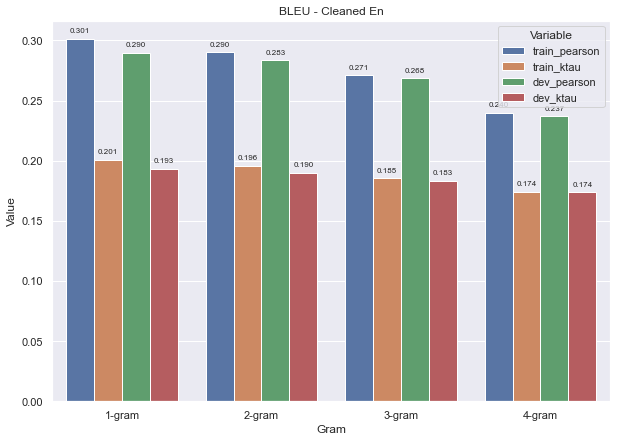

In [44]:
sns.set(rc={"figure.figsize":(10, 7)})
tidy = en_raw_df.melt(id_vars='gram').rename(columns=str.title)
fig = sns.barplot(x='Gram', y='Value', hue='Variable', data=tidy)
for bar in fig.patches:
    fig.annotate(format(bar.get_height(), '.3f'), 
                       (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                       size=8, xytext=(0, 8),
                       textcoords='offset points')
    fig.set_title('BLEU - Cleaned En')

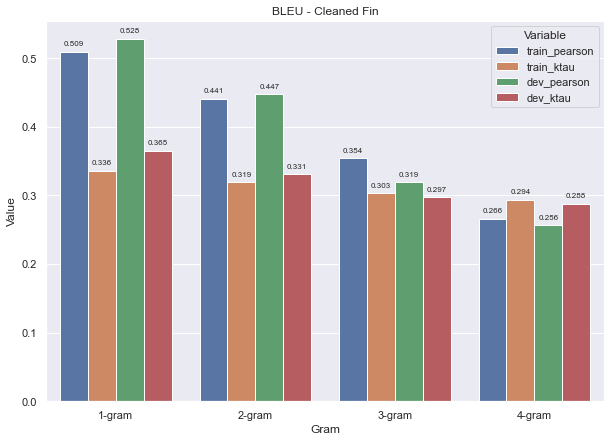

In [43]:
sns.set(rc={"figure.figsize":(10, 7)})
tidy = fin_raw_df.melt(id_vars='gram').rename(columns=str.title)
fig = sns.barplot(x='Gram', y='Value', hue='Variable', data=tidy)
for bar in fig.patches:
    fig.annotate(format(bar.get_height(), '.3f'), 
                       (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                       size=8, xytext=(0, 8),
                       textcoords='offset points')
    fig.set_title('BLEU - Cleaned Fin')

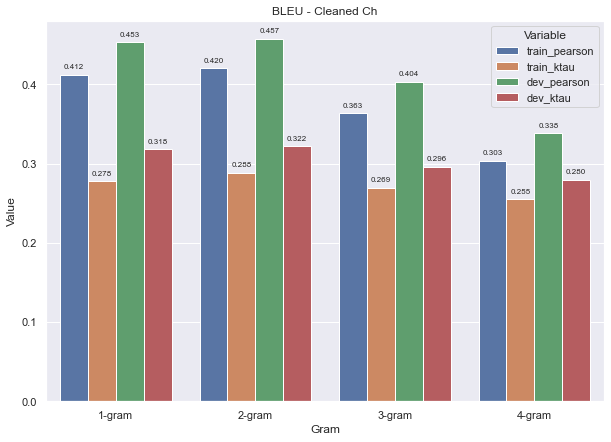

In [42]:
sns.set(rc={"figure.figsize":(10, 7)})
tidy = ch_raw_df.melt(id_vars='gram').rename(columns=str.title)
fig = sns.barplot(x='Gram', y='Value', hue='Variable', data=tidy)
for bar in fig.patches:
    fig.annotate(format(bar.get_height(), '.3f'), 
                       (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                       size=8, xytext=(0, 8),
                       textcoords='offset points')
    fig.set_title('BLEU - Cleaned Ch')

# BLEU (cleaned corpora)

In [18]:
raw_sets = [en_train_clean, en_dev_clean, en_test_clean, fin_train_clean, fin_dev_clean, fin_test_clean, ch_train_clean, ch_dev_clean, ch_test_clean]
raw_names = ['en_train_clean', 'en_dev_clean', 'en_test_clean', 'fin_train_clean', 'fin_dev_clean', 'fin_test_clean', 'ch_train_clean', 'ch_dev_clean', 'ch_test_clean']
for l in range(len(raw_sets)):
    print(raw_names[l])
    if l < 6:
        for i in range(1, 5):
            bleu_score(raw_sets[l], i)
    else:
        for i in range(1, 5):
            bleu_score(raw_sets[l], i, chinese = True)

en_train_clean
en_dev_clean
en_test_clean
fin_train_clean
fin_dev_clean
fin_test_clean
ch_train_clean
ch_dev_clean
ch_test_clean


In [20]:
en_clean_df = pd.DataFrame(columns= ['gram', 'train_pearson', 'train_ktau', 'dev_pearson', 'dev_ktau'])
fin_clean_df = en_clean_df.copy()
ch_clean_df = en_clean_df.copy()
print('English')
for i in range (1, 5):
    print(str(i) + '-gram')
    corr_list = corr(en_train_clean['z-score'], en_train_clean[str(i) + '-gram'], 
                     en_dev_clean['z-score'], en_dev_clean[str(i) + '-gram'], 
                     en_test_clean['z-score'], en_test_clean[str(i) + '-gram'], return_corr = True)
    en_clean_df = en_clean_df.append({'gram':str(i) + '-gram', 'train_pearson': corr_list[0], 'train_ktau': corr_list[1], 
                                  'dev_pearson': corr_list[2], 'dev_ktau': corr_list[3]}, ignore_index=True)
    
print()
print('Finnish')
for i in range (1, 5):
    print(str(i) + '-gram')
    corr_list = corr(fin_train_clean['z-score'], fin_train_clean[str(i) + '-gram'], 
                     fin_dev_clean['z-score'], fin_dev_clean[str(i) + '-gram'], 
                     fin_test_clean['z-score'], fin_test_clean[str(i) + '-gram'], return_corr = True)
    fin_clean_df = fin_clean_df.append({'gram':str(i) + '-gram', 'train_pearson': corr_list[0], 'train_ktau': corr_list[1], 
                                  'dev_pearson': corr_list[2], 'dev_ktau': corr_list[3]}, ignore_index=True)
print()
print('Chinese')
for i in range (1, 5):
    print(str(i) + '-gram')
    corr_list = corr(ch_train_clean['z-score'], ch_train_clean[str(i) + '-gram'], 
                     ch_dev_clean['z-score'], ch_dev_clean[str(i) + '-gram'], 
                     ch_test_clean['z-score'], ch_test_clean[str(i) + '-gram'], return_corr = True)
    ch_clean_df = ch_clean_df.append({'gram':str(i) + '-gram', 'train_pearson': corr_list[0], 'train_ktau': corr_list[1], 
                                  'dev_pearson': corr_list[2], 'dev_ktau': corr_list[3]}, ignore_index=True)

English
1-gram
Train - Pearson: 0.3007898882711333; Kendall Tau: 0.20017404288830293
Dev - Pearson: 0.28930084544123347; Kendall Tau: 0.1932067428574309
Test - Pearson: 0.3047431153999639; Kendall Tau: 0.2027637219263774
2-gram
Train - Pearson: 0.28957145528016764; Kendall Tau: 0.19469184567342454
Dev - Pearson: 0.27753556277032243; Kendall Tau: 0.18688073186152832
Test - Pearson: 0.29278691402405405; Kendall Tau: 0.19706146003275488
3-gram
Train - Pearson: 0.2702715166174466; Kendall Tau: 0.18407877893489033
Dev - Pearson: 0.2656186223576372; Kendall Tau: 0.18074664125093398
Test - Pearson: 0.2813576461849093; Kendall Tau: 0.1902968517911969
4-gram
Train - Pearson: 0.2411480682463999; Kendall Tau: 0.17305414780020778
Dev - Pearson: 0.23530460307654394; Kendall Tau: 0.17054567083557362
Test - Pearson: 0.25006928279591495; Kendall Tau: 0.18046011334247844

Finnish
1-gram
Train - Pearson: 0.5570731091505411; Kendall Tau: 0.35799648628736325
Dev - Pearson: 0.587084481179909; Kendall Tau: 

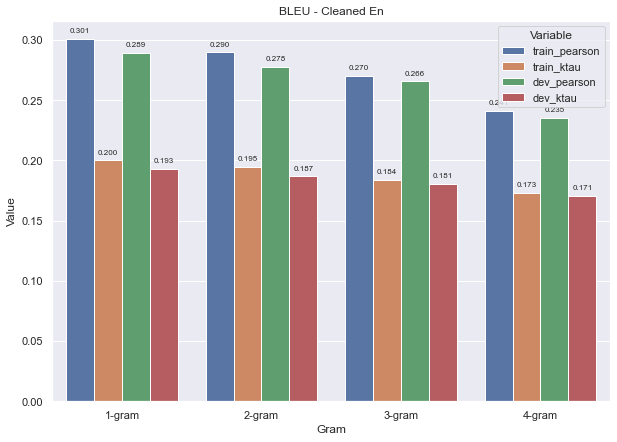

In [41]:
sns.set(rc={"figure.figsize":(10, 7)})
tidy = en_clean_df.melt(id_vars='gram').rename(columns=str.title)
fig = sns.barplot(x='Gram', y='Value', hue='Variable', data=tidy)
for bar in fig.patches:
    fig.annotate(format(bar.get_height(), '.3f'), 
                       (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                       size=8, xytext=(0, 8),
                       textcoords='offset points')
    fig.set_title('BLEU - Cleaned En')

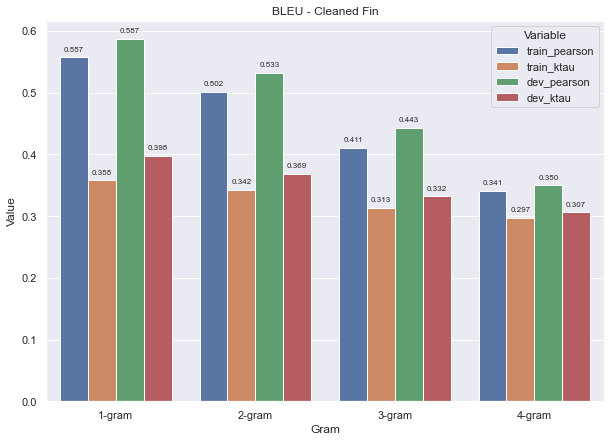

In [40]:
sns.set(rc={"figure.figsize":(10, 7)})
tidy = fin_clean_df.melt(id_vars='gram').rename(columns=str.title)
fig = sns.barplot(x='Gram', y='Value', hue='Variable', data=tidy)
for bar in fig.patches:
    fig.annotate(format(bar.get_height(), '.3f'), 
                       (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                       size=8, xytext=(0, 8),
                       textcoords='offset points')
    fig.set_title('BLEU - Cleaned Fin')

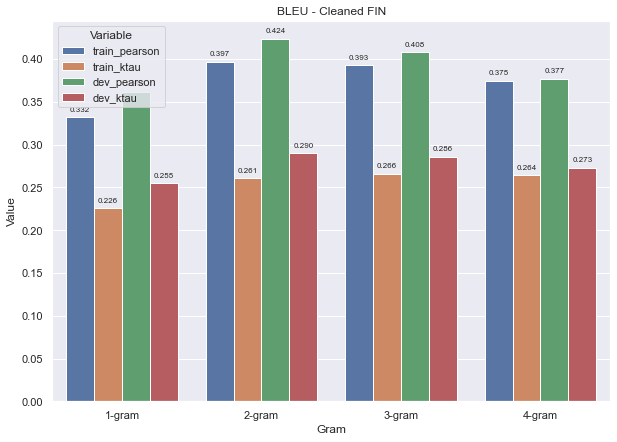

In [39]:
sns.set(rc={"figure.figsize":(10, 7)})
tidy = ch_clean_df.melt(id_vars='gram').rename(columns=str.title)
fig = sns.barplot(x='Gram', y='Value', hue='Variable', data=tidy)
for bar in fig.patches:
    fig.annotate(format(bar.get_height(), '.3f'), 
                       (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                       size=8, xytext=(0, 8),
                       textcoords='offset points')
    fig.set_title('BLEU - Cleaned Ch')